In [102]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
from hep_ml import reweight
from hep_ml.metrics_utils import ks_2samp_weighted
from sklearn.model_selection import train_test_split

In [103]:
columns    = ["gamma_PT","piminus_PT","nTracks"]
modes      = ["kpi","kpisw", "pipi"]
hist_style = {"bins" : 100, "density" : True, "alpha" : 1, "histtype" : "step"}
colors     = {"kpi" : "#066bd6", "kpisw"  : "#d60645",  "pipi" : "#0000ff", "ratio":"#000000"}

In [104]:
dataframes  = {}
path = "/Users/finnjohnonori/Documents/GitHubRepositories/HistogramsLHCbFull/data/"


# Imports the Kpi monte carlo data - Original
with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magup.root") as Kpi_TChain_MC_up: # type: ignore
    Kpi_TTree_up         = Kpi_TChain_MC_up["DecayTree"]
    Kpi_up_MC_df         = Kpi_TTree_up.arrays(columns, library="pd") # type: ignore

with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magdown.root") as Kpi_TChain_MC_down: # type: ignore
    Kpi_TTree_MC_down    = Kpi_TChain_MC_down["DecayTree"]
    Kpi_down_MC_df       = Kpi_TTree_MC_down.arrays(columns, library="pd") # type: ignore

dataframes["kpi"]        = pd.concat((Kpi_up_MC_df, Kpi_down_MC_df))


# Import the pipi monte carlo data
with uproot.open(path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel-magup.root") as pipi_TChain_MC_up: # type: ignore
   pipi_TTree_MC_up      = pipi_TChain_MC_up["DecayTree"]
   pipi_up_MC_df         = pipi_TTree_MC_up.arrays(columns, library="pd") # type: ignore

with uproot.open(path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel-magdown.root") as pipi_TChain_MC_down: # type: ignore
   pipi_TTree_MC_down    = pipi_TChain_MC_down["DecayTree"]
   pipi_down_MC_df       = pipi_TTree_MC_down.arrays(columns, library="pd") # type: ignore

dataframes["pipi"]       = pd.concat((pipi_up_MC_df, pipi_down_MC_df))


#Imports the Sample Data - Target
with uproot.open(path + "Sample_Kpigamma_2018_selectedTree_with_sWeights_Analysis_2hg_Unbinned-Mask1.root") as Kpi_TChain_SM: # type: ignore
    Kpi_TTree_SM         = Kpi_TChain_SM["DecayTree"]
    dataframes["kpisw"]  = Kpi_TTree_SM.arrays(columns + ["NB0_Kpigamma_sw"], library="pd", cut = "(abs(B_M01-895.55)<100)") # type: ignore

dataframes["kpisw"] = dataframes["kpisw"].reset_index(drop=True)



In [105]:
# divide original samples into training ant test parts
original_train, original_test = train_test_split(Kpi_down_MC_df)
# divide target samples into training ant test parts
target_train, target_test = train_test_split(dataframes["kpisw"])

original_weights_train = np.ones(len(original_train))
original_weights_test = np.ones(len(original_test))



In [106]:
bins_reweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.)

bins_reweighter.fit(original_train, target_train[columns], original_weight = original_weights_train, target_weight = target_train["NB0_Kpigamma_sw"]  )
bins_weights_test = bins_reweighter.predict_weights(original_test)

print(bins_weights_test)

[0.63287381 0.95142505 1.26866167 ... 0.70902598 1.13735206 0.60571703]


In [107]:
print(len(dataframes["kpi"  ]["gamma_PT"]))
print(len(bins_reweighter.predict_weights(dataframes["kpi"] )))

210684
210684


/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_66357/3469250960.py:19: RuntimeWarning: divide by zero encountered in divide
  ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_66357/3469250960.py:19: RuntimeWarning: invalid value encountered in divide
  ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_66357/3469250960.py:49: RuntimeWarning: divide by zero encountered in divide
  ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=0.0, posinf=0.0, neginf=0.0)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_66357/3469250960.py:49: RuntimeWarning: invalid value encountered in divide
  ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=0.0, posinf=0.0, neginf=0.0)


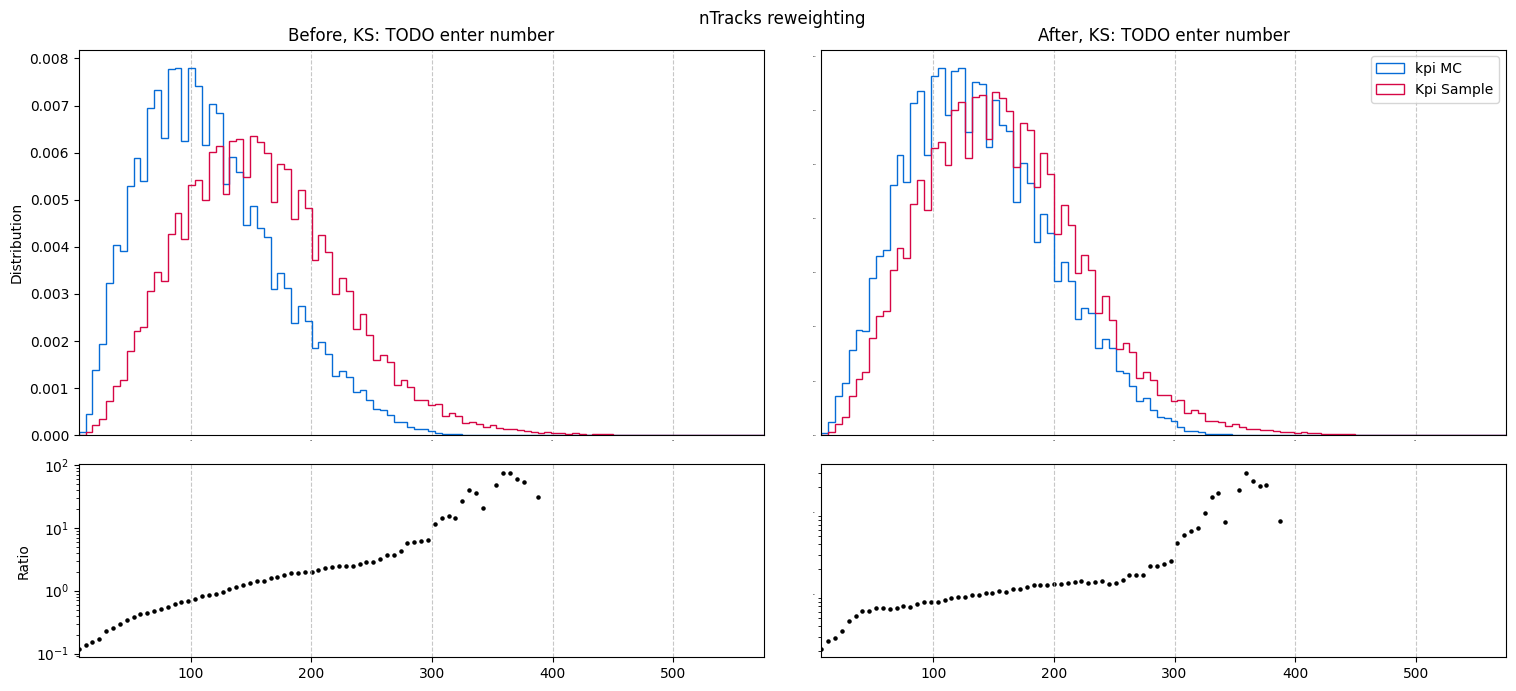

In [117]:
def createDoublePlot(variable):


    canvas, ((dist_original, dist_trained),(rati_original, rati_trained) ) = plt.subplots(2,2, gridspec_kw={"height_ratios" : [2,1] },figsize=(15, 7))
    canvas.suptitle(f"{variable} reweighting")
    canvas.tight_layout(h_pad=0)

    xlowerBound = min(min(dataframes["kpi"  ][variable]), min(dataframes["kpisw"][variable]))
    xupperBound = max(max(dataframes["kpi"  ][variable]), max(dataframes["kpisw"][variable]))

    #plot original histograms
    hist_kpi_y,   hist_kpi_x,   _  = dist_original.hist(dataframes["kpi"  ][variable], range=(xlowerBound, xupperBound), color=colors["kpi"  ], label="kpi MC",   **hist_style)
    hist_kpisw_y, hist_kpisw_x, _  = dist_original.hist(dataframes["kpisw"][variable], range=(xlowerBound, xupperBound), color=colors["kpisw"], label="Kpi Sample", **hist_style)

    dist_original.tick_params(axis="x", labelsize=0,length=0, width=0)
    dist_trained.tick_params(axis="both", labelsize=0,length=0, width=0)
    rati_trained.tick_params(axis="y", labelsize=0,length=0, width=0)

    ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=-1, posinf=-1, neginf=-1)

    rati_original.scatter(hist_kpisw_x[:-1], ratio_data, s=5, c=colors["ratio"])
    
    rati_original.grid(axis="x", linestyle="dashed", alpha=0.7)
    dist_original.grid(axis="x", linestyle="dashed", alpha=0.7)

    dist_original.set_title("Before, KS: TODO enter number")
    dist_original.set_ylabel("Distribution")
    rati_original.set_ylabel("Ratio")

    #ratioYlimhig = max(ratio_data)*1.1
    #ratioYlimlow = min(ratio_data)*1.1
    
    rati_original.set_yscale("log")
    rati_original.set_xlim(xlowerBound, xupperBound)
    dist_original.set_xlim(xlowerBound, xupperBound)


    #Train the weights
    bins_reweighter = reweight.BinsReweighter(n_bins=30, n_neighs=1.)
    bins_reweighter.fit(original_train, target_train[columns], original_weight = original_weights_train, target_weight = target_train["NB0_Kpigamma_sw"]  )
    trained_weights = bins_reweighter.predict_weights(dataframes["kpi"])

    #Plot trained histograms
    hist_kpi_y,   hist_kpi_x,   _  = dist_trained.hist(dataframes["kpi"  ][variable], range=(xlowerBound, xupperBound), color=colors["kpi"  ], weights=trained_weights, label="kpi MC",   **hist_style)
    hist_kpisw_y, hist_kpisw_x, _  = dist_trained.hist(dataframes["kpisw"][variable], range=(xlowerBound, xupperBound), color=colors["kpisw"], label="Kpi Sample", **hist_style)

    dist_trained.legend()

    ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=0.0, posinf=0.0, neginf=0.0)

    rati_trained.scatter(hist_kpisw_x[:-1],ratio_data, s=5, c=colors["ratio"])
    rati_trained.grid(axis="x", linestyle="dashed", alpha=0.7)
    dist_trained.grid(axis="x", linestyle="dashed", alpha=0.7)

    rati_trained.set_yscale("log")
    rati_trained.set_xlim(xlowerBound, xupperBound)
    dist_trained.set_xlim(xlowerBound, xupperBound)

    dist_trained.set_title("After, KS: TODO enter number")


createDoublePlot("nTracks")


/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_66357/3098664072.py:19: RuntimeWarning: divide by zero encountered in divide
  ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_66357/3098664072.py:19: RuntimeWarning: invalid value encountered in divide
  ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_66357/3098664072.py:49: RuntimeWarning: divide by zero encountered in divide
  ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=0.0, posinf=0.0, neginf=0.0)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_66357/3098664072.py:49: RuntimeWarning: invalid value encountered in divide
  ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=0.0, posinf=0.0, neginf=0.0)


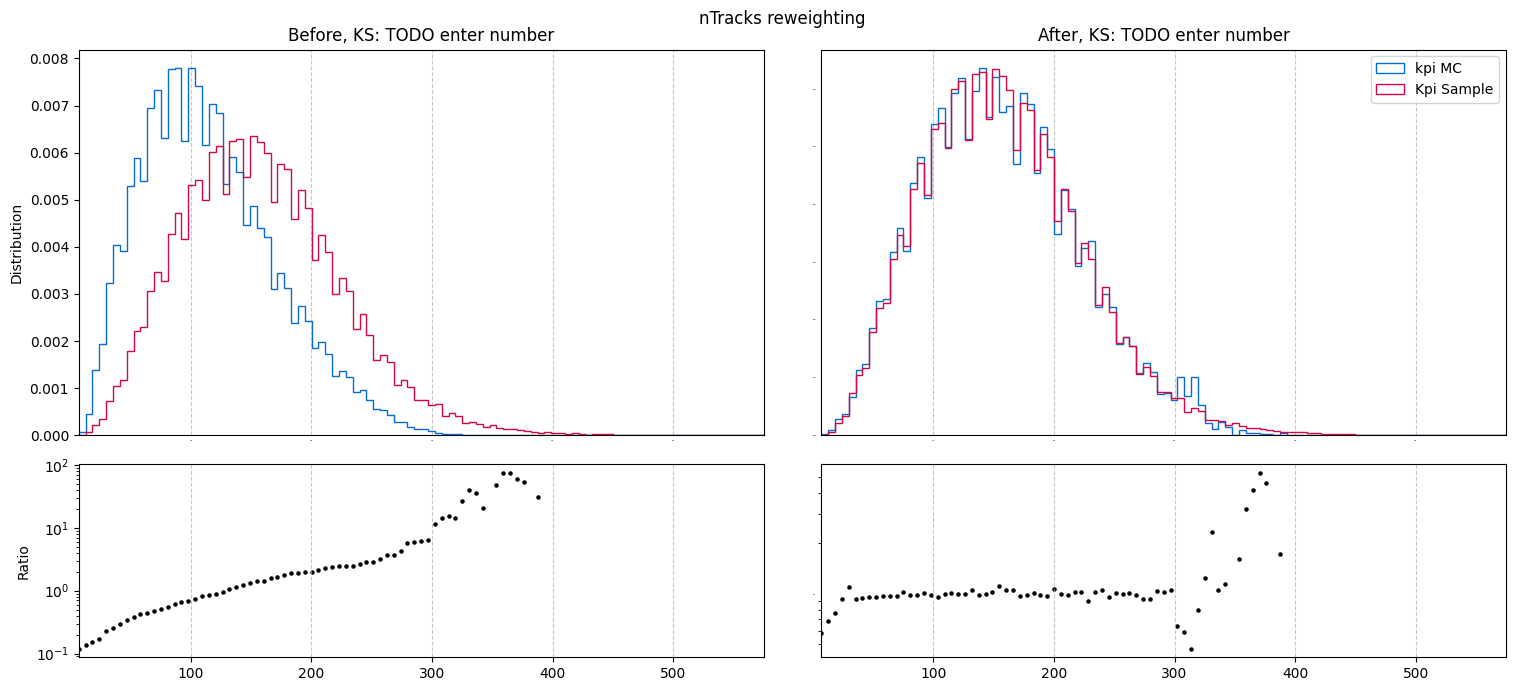

In [121]:
def createDoublePlotGB(variable):


    canvas, ((dist_original, dist_trained),(rati_original, rati_trained) ) = plt.subplots(2,2, gridspec_kw={"height_ratios" : [2,1] },figsize=(15, 7))
    canvas.suptitle(f"{variable} reweighting")
    canvas.tight_layout(h_pad=0)

    xlowerBound = min(min(dataframes["kpi"  ][variable]), min(dataframes["kpisw"][variable]))
    xupperBound = max(max(dataframes["kpi"  ][variable]), max(dataframes["kpisw"][variable]))

    #plot original histograms
    hist_kpi_y,   hist_kpi_x,   _  = dist_original.hist(dataframes["kpi"  ][variable], range=(xlowerBound, xupperBound), color=colors["kpi"  ], label="kpi MC",   **hist_style)
    hist_kpisw_y, hist_kpisw_x, _  = dist_original.hist(dataframes["kpisw"][variable], range=(xlowerBound, xupperBound), color=colors["kpisw"], label="Kpi Sample", **hist_style)

    dist_original.tick_params(axis="x", labelsize=0,length=0, width=0)
    dist_trained.tick_params(axis="both", labelsize=0,length=0, width=0)
    rati_trained.tick_params(axis="y", labelsize=0,length=0, width=0)

    ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=-1, posinf=-1, neginf=-1)
    rati_original.scatter(hist_kpisw_x[:-1], ratio_data, s=5, c=colors["ratio"])
    
    rati_original.grid(axis="x", linestyle="dashed", alpha=0.7)
    dist_original.grid(axis="x", linestyle="dashed", alpha=0.7)

    dist_original.set_title("Before, KS: TODO enter number")
    dist_original.set_ylabel("Distribution")
    rati_original.set_ylabel("Ratio")

    #ratioYlimhig = max(ratio_data)*1.1
    #ratioYlimlow = min(ratio_data)*1.1
    
    rati_original.set_yscale("log")
    rati_original.set_xlim(xlowerBound, xupperBound)
    dist_original.set_xlim(xlowerBound, xupperBound)


    #Train the weights
    bins_reweighter = reweight.GBReweighter(n_estimators=250, learning_rate=0.1, max_depth=3, min_samples_leaf=1000, gb_args={'subsample': 0.4})
    bins_reweighter.fit(original_train, target_train[columns])
    trained_weights = bins_reweighter.predict_weights(dataframes["kpi"])

    #Plot trained histograms
    hist_kpi_y,   hist_kpi_x,   _  = dist_trained.hist(dataframes["kpi"  ][variable], range=(xlowerBound, xupperBound), color=colors["kpi"  ], weights=trained_weights, label="kpi MC",   **hist_style)
    hist_kpisw_y, hist_kpisw_x, _  = dist_trained.hist(dataframes["kpisw"][variable], range=(xlowerBound, xupperBound), color=colors["kpisw"], label="Kpi Sample", **hist_style)

    dist_trained.legend()

    ratio_data = np.nan_to_num( (hist_kpisw_y / hist_kpi_y), nan=0.0, posinf=0.0, neginf=0.0)

    rati_trained.scatter(hist_kpisw_x[:-1],ratio_data, s=5, c=colors["ratio"])
    rati_trained.grid(axis="x", linestyle="dashed", alpha=0.7)
    dist_trained.grid(axis="x", linestyle="dashed", alpha=0.7)

    rati_trained.set_yscale("log")
    rati_trained.set_xlim(xlowerBound, xupperBound)
    dist_trained.set_xlim(xlowerBound, xupperBound)

    dist_trained.set_title("After, KS: TODO enter number")


createDoublePlotGB("nTracks")